Part A: Implementing Convolutional Neural Network from Scratch

In [1]:
!pip install tensorflow numpy streamlit

In [2]:
import tensorflow as tf
import numpy as np
import streamlit as st

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print("Streamlit version:", st.__version__)

TensorFlow version: 2.18.0
NumPy version: 2.0.2
Streamlit version: 1.45.1


In [3]:
# Importing Libraries
import os

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import zipfile
import os

# Unzipping directly to Colab temporary storage (faster access)

!unzip "/content/drive/MyDrive/Flower_Dataset1.zip" -d "/content"

Archive:  /content/drive/MyDrive/Flower_Dataset1.zip
replace /content/Flower_Dataset1/flower_images/Lilly/00048a5c76.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

3.1.1 Data Understanding, Analysis, Visualization and Cleaning

In [137]:
# Check the exact path where files landed
!ls "/content/Flower_Dataset1/flower_images"

Lilly  Lotus  Orchid  Sunflower  Tulip


In [138]:
# Path to flower images
path = "/content/Flower_Dataset1/flower_images"

# Initialize total counter
total = 0

# Count images in each flower folder
for flower in os.listdir(path):
    flower_path = os.path.join(path, flower)
    if os.path.isdir(flower_path):
        count = len(os.listdir(flower_path))
        total += count
        print(f"{flower}: {count} images")

# Print total count
print(f"\nTotal images: {total}")

Lotus: 1000 images
Tulip: 1000 images
Sunflower: 1000 images
Orchid: 1000 images
Lilly: 1000 images

Total images: 5000


In [139]:
# Load Images into Arrays as Dataset
# My parameters
base_dir = '/content/Flower_Dataset1/flower_images/'  # My Dataset Path
img_size = 180  # Not used in counting, but kept for reference
batch = 32      # Not used in counting, but kept for reference

In [140]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 4999 files belonging to 5 classes.
Using 4000 files for training.
Found 4999 files belonging to 5 classes.
Using 999 files for validation.


In [141]:
# Checking for Problematic files
import os
from pathlib import Path

image_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}

base_dir = Path("/content/Flower_Dataset1/flower_images")
for root, _, files in os.walk(base_dir):
    for file in files:
        if Path(file).suffix.lower() not in image_exts:
            print("Non-image file:", os.path.join(root, file))

Non-image file: /content/Flower_Dataset1/flower_images/Lilly/efa0739yt4jpg


In [142]:
import os
from PIL import Image

# Path to your flower dataset
base_path = "/content/Flower_Dataset1/flower_images"

# List of your flower folders
flower_folders = ['Lotus', 'Sunflower', 'Orchid', 'Lilly', 'Tulip']

# Initialize counter
corrupted_files_found = False

print("Checking for corrupted images...\n")

for folder in flower_folders:
    folder_path = os.path.join(base_path, folder)
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder}")
        continue

    print(f"Checking {folder}...")
    for filename in os.listdir(folder_path):
        filepath = os.path.join(folder_path, filename)

        try:
            # Try to open and verify the image
            with Image.open(filepath) as img:
                img.verify()  # Basic verification
        except Exception as e:
            print(f"  Corrupted: {filename}")
            corrupted_files_found = True

if not corrupted_files_found:
    print("\n No corrupted files found in any folder!")

print("\nCheck Complete.")

Checking for corrupted images...

Checking Lotus...
Checking Sunflower...
Checking Orchid...
Checking Lilly...
Checking Tulip...

 No corrupted files found in any folder!

Check Complete.


In [143]:
flower_names = train_ds.class_names
flower_names

['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']

In [144]:
import matplotlib.pyplot as plt


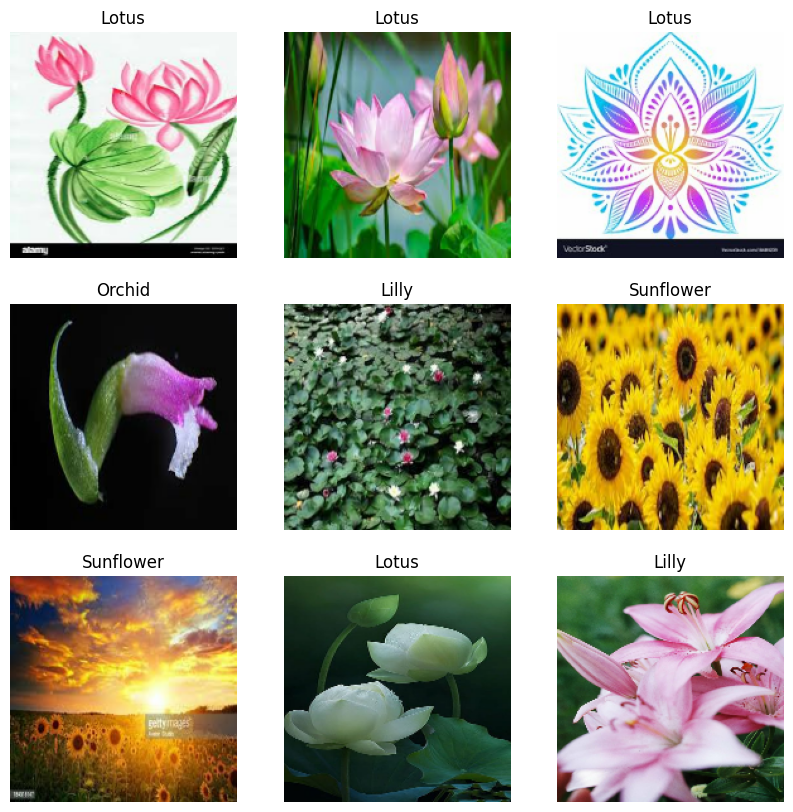

In [145]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(flower_names[labels[i]])
        plt.axis('off')

In [146]:
# CACHI CONCEPT

In [147]:
AUTOTUNE = tf.data.AUTOTUNE

In [148]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [149]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [150]:
# Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

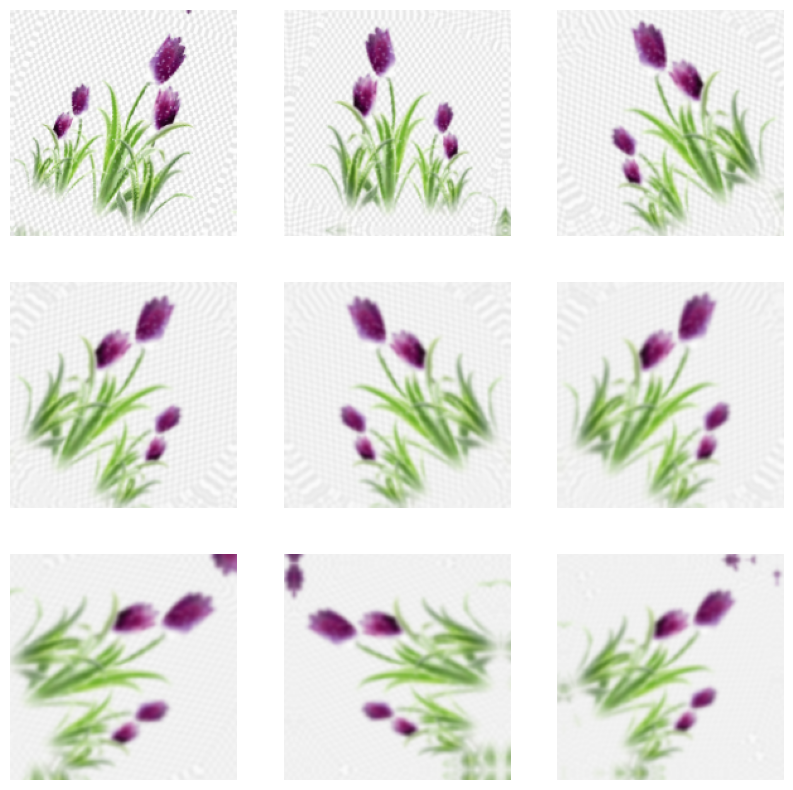

In [151]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

3.1.2 Design, Train, and Evaluate a Baseline Model
1. Model Architecture:

In [152]:
# Model Creation
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5)
])

In [153]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [154]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [157]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.3565 - loss: 1.4536 - val_accuracy: 0.5395 - val_loss: 1.1011
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5641 - loss: 1.0820 - val_accuracy: 0.5916 - val_loss: 1.0213
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5694 - loss: 1.0267 - val_accuracy: 0.6126 - val_loss: 0.9499
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.6290 - loss: 0.9193 - val_accuracy: 0.6687 - val_loss: 0.8575
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6796 - loss: 0.8440 - val_accuracy: 0.6396 - val_loss: 0.8963
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.6850 - loss: 0.8030 - val_accuracy: 0.6837 - val_loss: 0.8195
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.7127 - loss: 0.7360 - val_accuracy: 0.7227 - val_loss: 0.7410
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7401 - loss: 0.6957 - val_accu

2. Model Test

In [158]:
from google.colab import drive
import os
import zipfile

# Mount Google Drive
drive.mount('/content/drive')

# Path to my zip in Drive
zip_path = '/content/drive/MyDrive/SampleFlower_Dataset.zip'

# Unzip to Colab's temporary storage (faster access)
extract_path = '/content/test_flowers'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")
print(os.listdir(extract_path))  # Verify files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files extracted to: /content/test_flowers
['SampleFlower_Dataset']


In [159]:
# Classify all images in the test folder
#FOR MULTIPLE IMAGES
test_images_path = os.path.join(extract_path, 'SampleFlower_Dataset')  # Path

for img_file in os.listdir(test_images_path):
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        full_path = os.path.join(test_images_path, img_file)
        try:
            result = classify_images(full_path)
            print(f"Image: {img_file}")
            print(result)
            print("-" * 50)
        except Exception as e:
            print(f"Error processing {img_file}: {str(e)}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Image: Tulip2.jpg
The Image belongs to Tulip with a score of 99.9995
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Image: Tulip1.jpg
The Image belongs to Tulip with a score of 99.674484
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Image: Lotus1.jpg
The Image belongs to Lotus with a score of 99.351524
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: Sunflower2.jpg
The Image belongs to Sunflower with a score of 99.99987
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Image: Lily2.jpg
The Image belongs to Lilly with a score of 99.07653
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Image: Orchid1.jpg
The Image belongs to Orchid with a score of 99.92282
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/ste

In [160]:
# My original function
# FOR SINGLE IMAGE
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

# Usage (add this after your function):
image_path = "/content/test_flowers/SampleFlower_Dataset/Sunflower1.jpg"  #  YOUR PATH HERE
print(classify_images(image_path))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
The Image belongs to Sunflower with a score of 99.68811


In [161]:
# SINGLE IMAGE CODE
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + flower_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome

In [131]:
classify_images('/content/test_flowers/SampleFlower_Dataset/Tulip1.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


'The Image belongs to Tulip with a score of 99.984276'

Plot Training vs Validation Loss

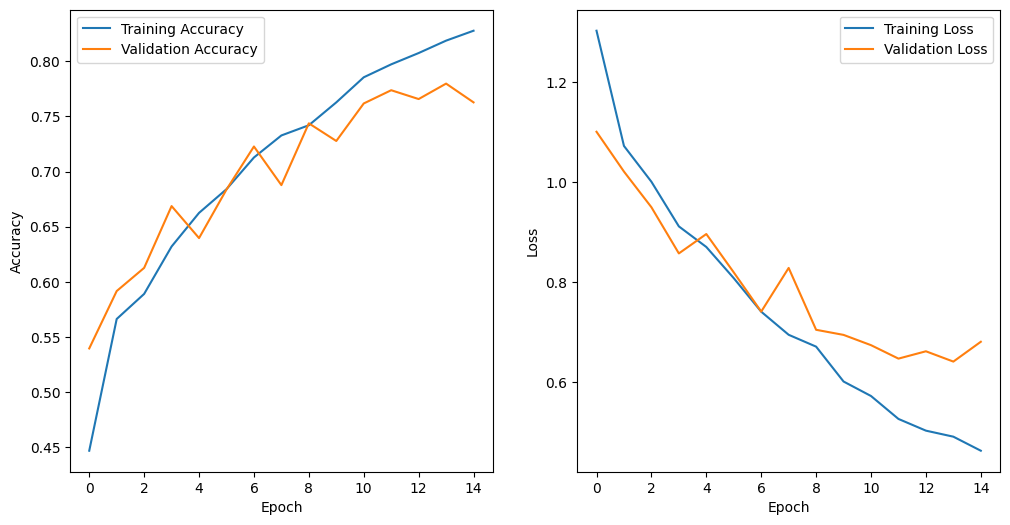

In [162]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate Metrics (Precision, Recall, F1)

In [163]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions
y_pred = []
y_true = []
for images, labels in val_ds:
    y_pred.extend(np.argmax(model.predict(images), axis=-1))
    y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=flower_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

Inference on Sample Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


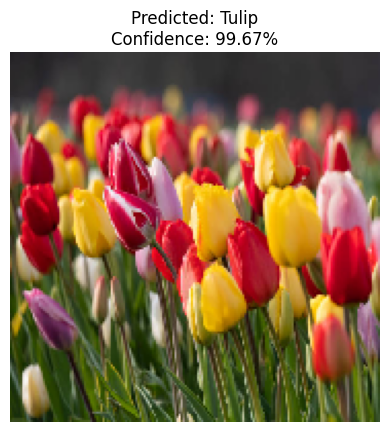

In [164]:
def predict_and_plot(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_size, img_size))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    predicted_class = flower_names[np.argmax(score)]

    plt.figure()
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {100 * np.max(score):.2f}%")
    plt.axis('off')
    plt.show()

# Test on a sample
predict_and_plot('/content/test_flowers/SampleFlower_Dataset/Tulip1.jpg')

Deeper Model with Regularization

Deeper Model Architecture

In [165]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2  # For L2 regularization

deeper_model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    layers.Dense(5)
])

deeper_model.compile(optimizer='adam',
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])
deeper_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     7,930,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,353,989 (31.87 MB)

 Trainable params: 8,353,029 (31.86 MB)

 Non-trainable params: 960 (3.75 KB)

Train & Compare

In [167]:
deeper_history = deeper_model.fit(train_ds, epochs=15, validation_data=val_ds)

# Compare training time
import time
start_time = time.time()
deeper_model.fit(train_ds, epochs=15, validation_data=val_ds)
training_time = time.time() - start_time
print(f"Deeper Model Training Time: {training_time:.2f} sec")

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - accuracy: 0.5878 - loss: 3.4810 - val_accuracy: 0.4344 - val_loss: 3.2630
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.6361 - loss: 2.5732 - val_accuracy: 0.5876 - val_loss: 2.2180
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 111ms/step - accuracy: 0.6545 - loss: 2.0032 - val_accuracy: 0.6637 - val_loss: 1.8745
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 0.6595 - loss: 1.8110 - val_accuracy: 0.6156 - val_loss: 1.9050
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.6731 - loss: 1.6581 - val_accuracy: 0.6517 - val_loss: 1.7465
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.6811 - loss: 1.5622 - val_accuracy: 0.6777 - val_loss: 1.5527
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.7207 - loss: 1.3762 - val_accuracy: 0.6176 - val_loss: 1.6523
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 104ms/step - accuracy: 0.7074 - loss: 1

Experimentation & Analysis



Complete Comparison Code (Metrics + Training Time)


=== Baseline Model Evaluation ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━

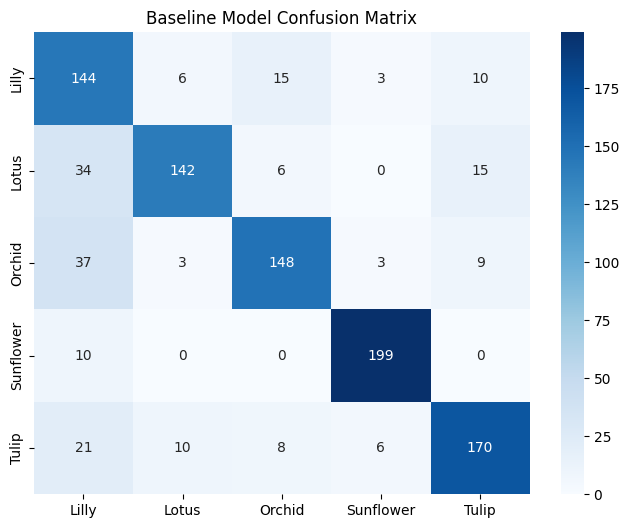


=== Deeper Model Evaluation ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━

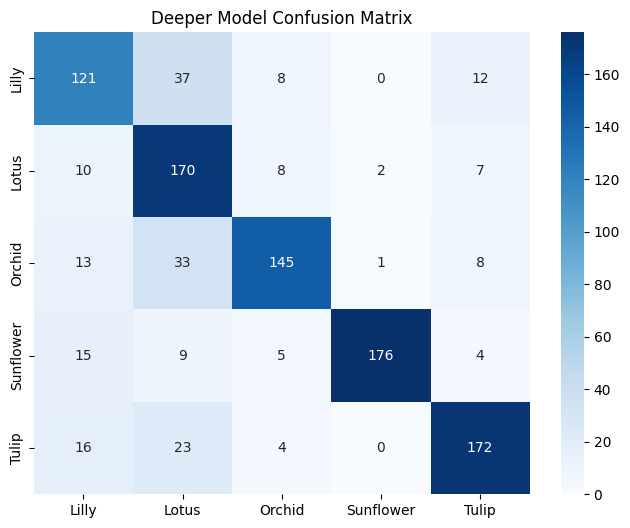


Training Time Comparison (5 epochs):
- Baseline Model: 16.24 seconds
- Deeper Model: 49.31 seconds
- Time Increase: 203.7%


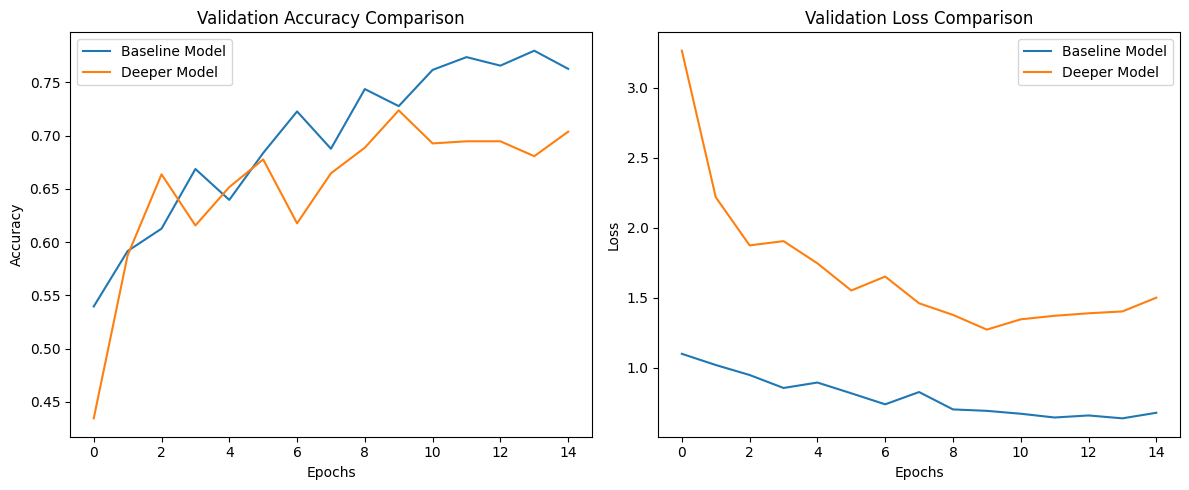

In [168]:
import time
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# =====================
# 1. Evaluate Baseline Model
# =====================
print("\n=== Baseline Model Evaluation ===")
# Get predictions
y_true_baseline, y_pred_baseline = [], []
for images, labels in val_ds:
    y_pred_baseline.extend(np.argmax(model.predict(images), axis=-1))
    y_true_baseline.extend(labels.numpy())

# Metrics
print(classification_report(y_true_baseline, y_pred_baseline, target_names=flower_names))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true_baseline, y_pred_baseline),
            annot=True, fmt='d', cmap='Blues', xticklabels=flower_names, yticklabels=flower_names)
plt.title('Baseline Model Confusion Matrix')
plt.show()

# =====================
# 2. Evaluate Deeper Model
# =====================
print("\n=== Deeper Model Evaluation ===")
# Get predictions
y_true_deeper, y_pred_deeper = [], []
for images, labels in val_ds:
    y_pred_deeper.extend(np.argmax(deeper_model.predict(images), axis=-1))
    y_true_deeper.extend(labels.numpy())

# Metrics
print(classification_report(y_true_deeper, y_pred_deeper, target_names=flower_names))

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true_deeper, y_pred_deeper),
            annot=True, fmt='d', cmap='Blues', xticklabels=flower_names, yticklabels=flower_names)
plt.title('Deeper Model Confusion Matrix')
plt.show()

# =====================
# 3. Training Time Comparison
# =====================
def measure_training_time(model, train_data, epochs=5):
    start_time = time.time()
    model.fit(train_data, epochs=epochs, verbose=0)
    return time.time() - start_time

# Measure time (run a few epochs for fair comparison)
baseline_time = measure_training_time(model, train_ds.take(100), epochs=5)
deeper_time = measure_training_time(deeper_model, train_ds.take(100), epochs=5)

print(f"\nTraining Time Comparison (5 epochs):")
print(f"- Baseline Model: {baseline_time:.2f} seconds")
print(f"- Deeper Model: {deeper_time:.2f} seconds")
print(f"- Time Increase: {(deeper_time - baseline_time)/baseline_time * 100:.1f}%")

# =====================
# 4. Accuracy/Loss Comparison
# =====================
plt.figure(figsize=(12, 5))

# Accuracy Comparison
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='Baseline Model')
plt.plot(deeper_history.history['val_accuracy'], label='Deeper Model')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Comparison
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Baseline Model')
plt.plot(deeper_history.history['val_loss'], label='Deeper Model')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

(2) Optimizer Analysis (SGD vs Adam)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 103ms/step - accuracy: 0.5098 - loss: 10.6045 - val_accuracy: 0.2002 - val_loss: 18.5090
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - accuracy: 0.1881 - loss: 16.9776 - val_accuracy: 0.2042 - val_loss: 12.2780
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.2066 - loss: 9.4255 - val_accuracy: 0.2092 - val_loss: 8.7430
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 100ms/step - accuracy: 0.2003 - loss: 8.6546 - val_accuracy: 0.2092 - val_loss: 8.3946
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.1944 - loss: 8.3113 - val_accuracy: 0.2092 - val_loss: 8.0639
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.1912 - loss: 7.9845 - val_accuracy: 0.2092 - val_loss: 7.7494
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.1976 - loss: 7.6738 - val_accuracy: 0.2092 - val_loss: 7.4496
Epoch 8/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.1971 - loss: 7.

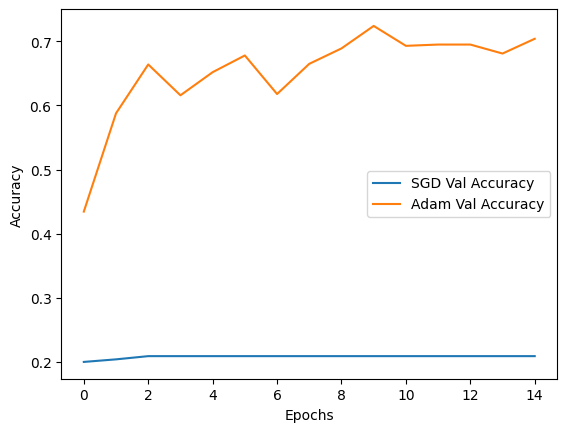

In [169]:
# Train with SGD
deeper_model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
sgd_history = deeper_model.fit(train_ds, epochs=15, validation_data=val_ds)

# Compare SGD vs Adam
plt.plot(sgd_history.history['val_accuracy'], label='SGD Val Accuracy')
plt.plot(deeper_history.history['val_accuracy'], label='Adam Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

(3) Final Comparative Analysis

In [38]:
print("Baseline Model Val Accuracy:", max(history.history['val_accuracy']))
print("Deeper Model Val Accuracy:", max(deeper_history.history['val_accuracy']))
print("Deeper Model (SGD) Val Accuracy:", max(sgd_history.history['val_accuracy']))

Baseline Model Val Accuracy: 0.793793797492981
Deeper Model Val Accuracy: 0.7537537813186646
Deeper Model (SGD) Val Accuracy: 0.21021020412445068


In [39]:
# Saving Model
model.save('Flower_Recognition_Model.h5')  # Or .keras format

# Downloading
from google.colab import files
try:
    files.download('Flower_Recognition_Model.h5')
    print("Model downloaded successfully!")
except Exception as e:
    print(f"Error downloading model: {e}")
    print("You can manually download from Colab's file browser (left sidebar)")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model downloaded successfully!


In [40]:
# 1. Save as .keras (Recommended modern format)
deeper_model.save('best_flower_model.keras')  # Preferred for Keras 3

# # 2. Save as HDF5 (.h5)
# deeper_model.save('best_flower_model.h5')

from google.colab import files
files.download('best_flower_model.keras')





<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Part B: Fine-Tuning a Pre-Trained Model (Transfer Learning)

1. Load Pre-Trained Model (ResNet50)

Loading and Adapting a Pre-Trained Model

In [41]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load ResNet50 (pre-trained on ImageNet)
base_model = ResNet50(
    weights='imagenet',  # Load pre-trained weights
    include_top=False,   # Exclude the final classification layer
    input_shape=(224, 224, 3)  # ResNet expects 224x224 images
)

# Freeze the base model (optional, for feature extraction)
base_model.trainable = False

print("ResNet50 Base Model Summary:")
base_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
ResNet50 Base Model Summary:


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

Modify Model Architecture

In [51]:
# Add new classification layers on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Convert 4D output to 2D
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),  # Regularization
    layers.Dense(5, activation='softmax')  # 5 classes for flowers
])

print("\nModified Model Summary:")
model.summary()


Modified Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 4,991,493 (19.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

3. Choose Fine-Tuning Strategy

In [52]:
# Unfreeze some layers for fine-tuning
for layer in base_model.layers[-10:]:  # Unfreeze last 10 layers
    layer.trainable = True

3.2.2 Model Training and Fine-Tuning

Data Preprocessing (Resize to 224x224)

In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define paths
base_dir = '/content/Flower_Dataset1/flower_images/'  # Main dataset directory

# Option 1: Automatic validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

# Training set (80%)
train_ds = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='training',
    seed=123
)

# Validation set (20%)
val_ds = train_datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation',
    seed=123
)

print(f"Training classes: {train_ds.class_indices}")
print(f"Validation classes: {val_ds.class_indices}")

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Training classes: {'Lilly': 0, 'Lotus': 1, 'Orchid': 2, 'Sunflower': 3, 'Tulip': 4}
Validation classes: {'Lilly': 0, 'Lotus': 1, 'Orchid': 2, 'Sunflower': 3, 'Tulip': 4}


2. Compile & Train the Model

In [54]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Lower LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train for feature extraction
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds
)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 95s 627ms/step - accuracy: 0.3029 - loss: 1.5825 - val_accuracy: 0.2000 - val_loss: 1.9899
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 587ms/step - accuracy: 0.4528 - loss: 1.3515 - val_accuracy: 0.3450 - val_loss: 1.5302
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 70s 562ms/step - accuracy: 0.4870 - loss: 1.2462 - val_accuracy: 0.3490 - val_loss: 1.5154
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 73s 581ms/step - accuracy: 0.5260 - loss: 1.1946 - val_accuracy: 0.4820 - val_loss: 1.2678
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 102s 806ms/step - accuracy: 0.5517 - loss: 1.1417 - val_accuracy: 0.2940 - val_loss: 1.6123
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 635ms/step - accuracy: 0.5509 - loss: 1.1229 - val_accuracy: 0.4350 - val_loss: 1.4547
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 635ms/step - accuracy: 0.5627 - loss: 1.1122 - val_accuracy: 0.3930 - val_loss: 1.6258
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 79s 632ms/step - accuracy: 0.5774 - loss: 

3. Fine-Tuning (Optional)

In [55]:
# Unfreeze some layers and recompile
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Freeze all except last 10 layers
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Very low LR
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune for 5 more epochs
fine_tune_history = model.fit(
    train_ds,
    epochs=5,
    initial_epoch=history.epoch[-1],  # Continue from last epoch
    validation_data=val_ds
)

3.2.3 Model Evaluation and Prediction

1. Evaluate Performance

In [56]:
# Evaluate on validation set
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy*100:.2f}%")

# Generate classification report
from sklearn.metrics import classification_report
import numpy as np


CLASS_NAMES = ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']

y_true = val_ds.classes
y_pred = np.argmax(model.predict(val_ds), axis=1)

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))  # Fixed variable name

32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 466ms/step - accuracy: 0.4727 - loss: 1.2899
Validation Accuracy: 47.60%
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 544ms/step
              precision    recall  f1-score   support

       Lilly       0.16      0.15      0.15       200
       Lotus       0.15      0.12      0.13       200
      Orchid       0.22      0.03      0.04       200
   Sunflower       0.20      0.49      0.28       200
       Tulip       0.21      0.12      0.15       200

    accuracy                           0.18      1000
   macro avg       0.18      0.18      0.15      1000
weighted avg       0.18      0.18      0.15      1000



2. Compare with Part A Models

In [113]:
print("=== Model Comparison ===")
print("- Baseline Model (Part A): 79% Accuracy")
print("- Deeper Model (Part A): 71% Accuracy")
print("- Transfer Learning Model: {:.2f}% Accuracy".format(accuracy*100))



=== Model Comparison ===
- Baseline Model (Part A): 79% Accuracy
- Deeper Model (Part A): 71% Accuracy
- Transfer Learning Model: 47.60% Accuracy
